In [1]:
%load_ext autoreload
%autoreload 2

from setup import setup_project_env
setup_project_env('~/weatherpy-work')

In [293]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from datasrcs.ibtracs import atlantic_tcs
from datasrcs.atcf import btk

In [288]:
ds = atlantic_tcs()

/Users/jitang/anaconda/envs/storm_analysis_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (3,21,128,148) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [4]:
post_1970 = ds[ds.season.isin(range(1970, 2019))]

In [5]:
deg = 90 - post_1970.storm_dir
post_1970['storm_dir_rad'] = np.radians(deg)

/Users/jitang/anaconda/envs/storm_analysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
post_1970[['sid', 'season', 'number', 'name', 'iso_time', 'lat', 'lon', 'storm_speed', 'storm_dir', 'storm_dir_rad']].tail()

,sid,season,number,name,iso_time,lat,lon,storm_speed,storm_dir,storm_dir_rad
119054,2018300N25315,2018,40,OSCAR,2018-11-04 00:00:00,59.8000,-14.5000,15.0,54.0,0.628319
119055,2018300N25315,2018,40,OSCAR,2018-11-04 03:00:00,60.2449,-13.3185,15.0,50.0,0.698132
119056,2018300N25315,2018,40,OSCAR,2018-11-04 06:00:00,60.8000,-12.1000,18.0,45.0,0.785398
119057,2018300N25315,2018,40,OSCAR,2018-11-04 09:00:00,61.5472,-10.6887,21.0,42.0,0.837758
119058,2018300N25315,2018,40,OSCAR,2018-11-04 12:00:00,62.4000,-9.1000,22.0,41.0,0.855211


In [309]:
from geopy.distance import great_circle

def forward_motion(df, periods=1, cols=None):
    if cols is None:
        cols = dict(
            storm_id='sid',
            timestamp='iso_time',
            lat='lat',
            lon='lon'
        )
#     cols = ['sid', 'name', timestamp_col, lat_col, lon_col]
#     df = df[df.iso_time.dt.hour.isin([0, 6, 12, 18])][cols]
    df = df[cols.values()]
    
    shifted = df.groupby(cols['storm_id']).shift(-periods)
    deltas = df.join(shifted, lsuffix='_0', rsuffix='_1')
    
    lat0 = np.radians(deltas.lat_0)
    lat1 = np.radians(deltas.lat_1)
    delta_lon = np.radians(deltas.lon_1 - deltas.lon_0)
    y = np.sin(delta_lon) * np.cos(lat1)
    x = np.cos(lat0) * np.sin(lat1) - (np.sin(lat0) * np.cos(lat1) * np.cos(delta_lon))
    angles = np.arctan2(y, x)
    angles = np.pi / 2 - angles  # convert bearing to angles
    
    def dist_nm(row):
        r_lat0, r_lon0, r_lat1, r_lon1 = row.lat_0, row.lon_0, row.lat_1, row.lon_1
        if np.any(np.isnan([r_lat0, r_lat1, r_lon0, r_lon1])):
            return np.nan
            
        pt0 = (r_lat0, r_lon0)
        pt1 = (r_lat1, r_lon1)
        return great_circle(pt0, pt1).nm
    
    dists = deltas.apply(dist_nm, axis=1) 
    speeds = np.abs(dists / (periods * 6))
    
    return dists, speeds, angles

In [310]:
post_1970 = post_1970[post_1970.iso_time.dt.hour.isin([0, 6, 12, 18])]
dists, speeds, angles = forward_motion(post_1970, 6)
post_1970_copy = post_1970.copy()

post_1970_copy['speed_calc'] = speeds
post_1970_copy['dist_calc'] = dists
post_1970_copy['angle_calc'] = angles

in_bbox = post_1970_copy

in_bbox = post_1970_copy[
    (post_1970_copy.lat >= 20) & (post_1970_copy.lat <= 30)
    & (post_1970_copy.lon >= -100) & (post_1970_copy.lon <= -65)
]

in_bbox = in_bbox[in_bbox.iso_time.dt.month.isin([8, 9])]

In [311]:
stallers = in_bbox[in_bbox.dist_calc < 100]

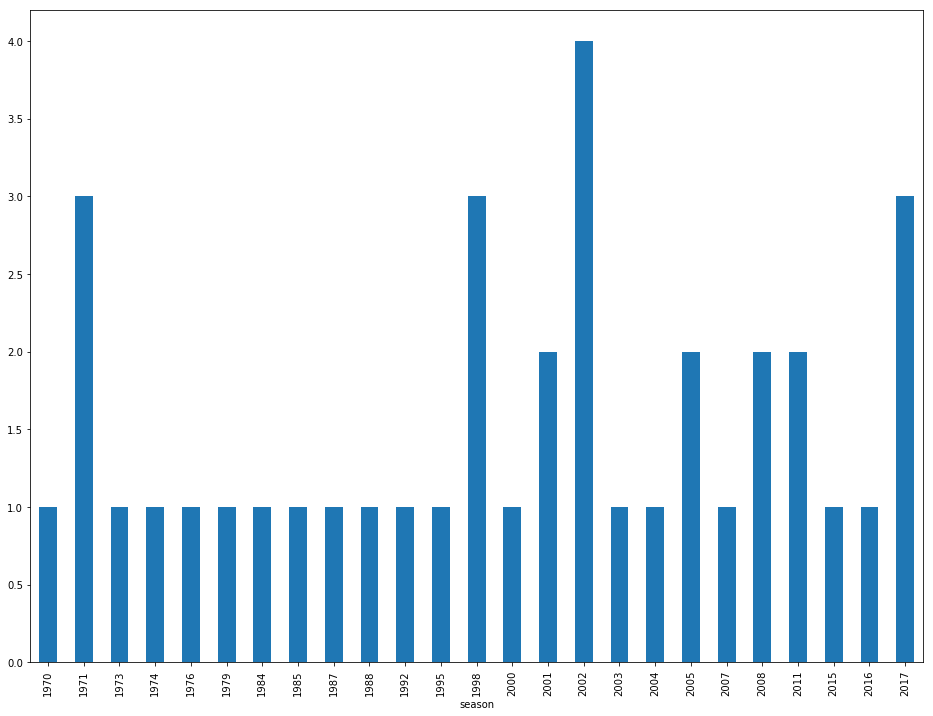

In [312]:
fig = plt.figure(figsize=(16, 12))
unique_byyear = stallers.groupby('season').nunique()['sid']
unique_byyear.plot(kind='bar')

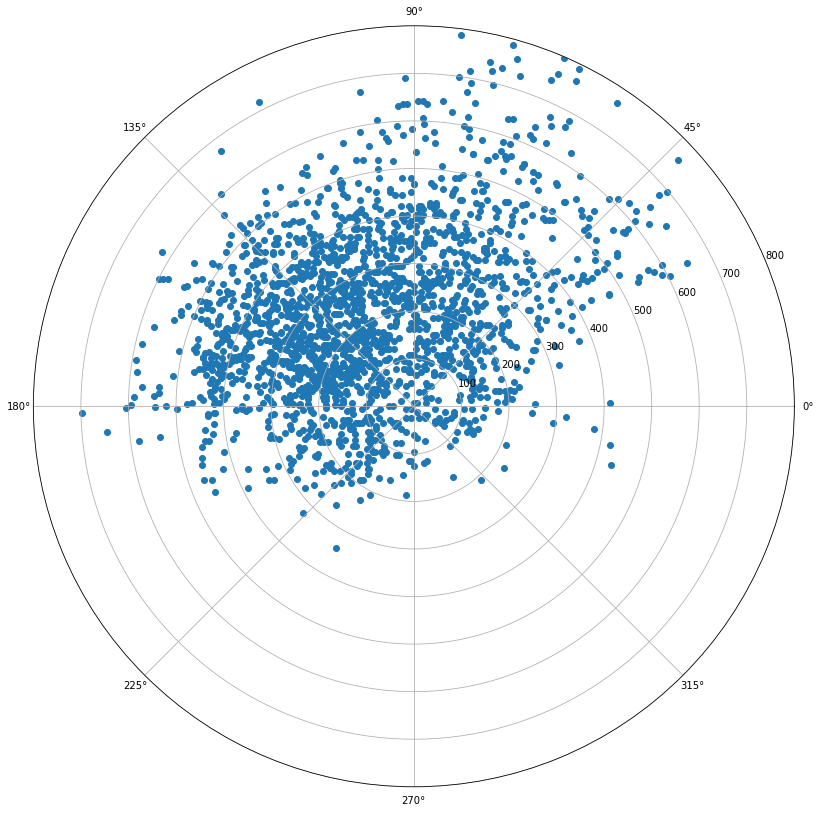

In [313]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='polar')
ax.scatter(in_bbox.angle_calc, in_bbox.dist_calc)

ax.set_rmax(800)

In [335]:
def identify_stalls(df, threshold_nm, time_periods, cols=None):
    if cols is None:
        cols = dict(
            storm_id='sid',
            timestamp='iso_time',
            lat='lat',
            lon='lon'
        )
    df = df[df[cols['timestamp']].dt.hour.isin([0, 6, 12, 18])]
    
    queries = []
    for i in range(1, time_periods + 1):
        dists, _, _ = forward_motion(df, i, cols=cols)
        queries.append(dists <= threshold_nm)
        
    stall_query = pd.concat(queries, axis=1).all(axis=1)
#     print(stall_query)
    return df[stall_query]

In [357]:
deep_stalls = identify_stalls(post_1970, 72, 6)

In [362]:
deep_stalls_50kt = deep_stalls[deep_stalls.wmo_wind >= 50]
deep_stalls_50kt.groupby(['season' ,'name']).nunique()['iso_time']

season  name     
1971    GINGER       2
        LAURA        2
1972    BETTY        1
1973    GILDA        1
1974    CARMEN       1
1979    HENRI        3
1980    JEANNE       1
1982    ALBERTO      1
1984    DIANA        3
1985    JUAN         2
1989    GABRIELLE    1
1992    BONNIE       7
        CHARLEY      3
1993    EMILY        1
1995    FELIX        2
        IRIS         1
        NOEL         1
        ROXANNE      2
1996    MARCO        1
1997    DANNY        4
1998    MITCH        7
1999    DENNIS       6
2000    FLORENCE     3
        KEITH        6
2001    FELIX        3
        OLGA         1
2002    ISIDORE      1
        KYLE         1
2003    LARRY        1
        NICHOLAS     2
2005    OPHELIA      4
        ZETA         1
2006    GORDON       2
2008    BERTHA       4
2009    FRED         4
2011    NATE         3
2012    LESLIE       7
2016    GASTON       1
        HERMINE      1
        NICOLE       1
2017    HARVEY       3
        JOSE         4
        KATIA   

In [340]:
dorian = btk('al052019')

In [345]:
dorian_firsts = dorian.groupby(['cy', 'yyyymmddhh']).first().reset_index().sort_values(by='ts')
dorian_firsts.tail()

,cy,yyyymmddhh,basin,technum,tech,tau,lat,lon,vmax,mslp,...,userdata1,userdefine2,userdata2,userdefine3,userdata3,userdefine4,userdata4,userdefine5,userdata5,ts
51,5,2019090406,AL,,BEST,0,28.8,-79.2,95,964,...,13,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-04 06:00:00
52,5,2019090412,AL,,BEST,0,29.5,-79.6,90,964,...,13,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-04 12:00:00
53,5,2019090418,AL,,BEST,0,30.1,-79.7,90,964,...,13,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-04 18:00:00
54,5,2019090500,AL,,BEST,0,30.7,-79.7,100,958,...,13,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-05 00:00:00
55,5,2019090506,AL,,BEST,0,31.4,-79.6,100,957,...,13,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-05 06:00:00


In [359]:
atcf_cols = dict(
    storm_id='cy',
    timestamp='ts',
    lat='lat',
    lon='lon'
)
dorian_stalls = identify_stalls(dorian_firsts, 72, 6, cols=atcf_cols)

In [360]:
dorian_stalls

,cy,yyyymmddhh,basin,technum,tech,tau,lat,lon,vmax,mslp,...,userdata1,userdefine2,userdata2,userdefine3,userdata3,userdefine4,userdata4,userdefine5,userdata5,ts
42,5,2019090200,AL,,BEST,0,26.6,-77.7,155,914,...,13,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-02 00:00:00
43,5,2019090206,AL,,BEST,0,26.6,-78.1,145,916,...,13,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-02 06:00:00
